# Reproducing Geophysics: Wheeler and Hale (2015)'s well log alignment using dynamic warping
*by Alan Richardson (Ausar Geophysical)*

## Introduction to the series

This is the first instalment of my *Reproducing Geophysics* series, where I attempt to implement published exploration geophysics algorithms and reproduce results.

Writing about someone else's baby is obviously a risky business. Rather than implementing algorithms exactly as described in the original publication, my goal in this series is to write the simplest code I can that still achieves what I think will be approximately the same effect. It is likely that I will also cut some corners when creating results. The original authors probably laboured for months to get the best results possible, while I am more interested in a quick peek. This means that my results will almost never be as good as those in the original papers. So, if I get bad results, it just means that the original authors worked harder than I did, and we should applaud them for their dedication.

My plan is to release a Python package with each instalment. This implements the chosen method, so you can install it and apply it to your own data. The associated Jupyter Notebook (like the one you are reading) will import this package, apply it to some data, and then visualise the output.

## Introduction to Wheeler and Hale (2015)

* [Research Report](http://cwp.mines.edu/Documents/cwpreports/cwp814.pdf)
* [MS Thesis](http://cwp.mines.edu/Documents/cwpreports/cwp826.pdf)
* [Youtube Video 1](https://www.youtube.com/watch?v=JIDIV1uDLXY)
* [Youtube Video 2](https://www.youtube.com/watch?v=vUsvKvGnXvE)

The Research Report is a nice introduction, but omits the important details of how to solve the system of equations, which you need to go to the MS Thesis for.

The method I have chosen to have a look at this time is designed to align well logs. To achieve this, it uses the concept of *Relative Geologic Time* (RGT). This indicates the order in which geologic layers were deposited (smaller values were deposited after larger ones). The method claims to assign an RGT value to each depth in the input well logs. Although it may be helpful to think about the output of the method as RGT, it can also be misleading (see next paragraph). What the method really does is assign a value to each depth in each log such that, if logs from two wells are plotted using this new value instead of depth on the y-axis, they should line-up.

RGT will probably not increase linearly along a log. If a portion of geologic time is represented on log `A` that is missing from log `B`, then there should be a jump in log `B`'s RGT at the unconformity. The method's output should do this too, so this matches well with calling the output RGT. This breaks down when the geology is more complicated than a simple case of newer deposits on top of older ones, as the output of the method is strictly increasing. As long as someone later in the processing flow doesn't mistakenly think the value is actually Relative Geologic Time, it shouldn't be a problem. It might be safer to call it something like Alignment Index, though. Despite these reservations, I will continue to refer to the output as RGT to be consistent with the original publications.

### Dynamic warping

Now that we have that quibble out of the way, let's see how the method actually produces the RGT values.

The first step is to use dynamic warping on every possible unordered pairing of the logs. If you have three logs, `A`, `B`, and `C`, there will be three such pairings: `(A, B)`, `(A, C)`, and `(B, C)`. By *unordered* I mean that `(A, B)` and `(B, A)` are the same.

Dynamic warping, usually called dynamic time warping (DTW) in the signal processing community, determines the way in which two signals need to be stretched and shifted for them to align. Given two signals, `A` and `B`, it will produce a list of index pairs `(i, j)`, such that `A[i] ~ B[j]`. Let's look at an example.

Here are our two signals (our well logs):

```
A = 12, 13, 14, 15, 9, 10
B = 10, 11, 12, 13, 14, 15, 12, 10, 8, 9
```

Applying dynamic warping produces a list of index pairs:

```
(i, j) = (1, 3), (2, 4), (3, 5), (4, 6), (5, 9)
```

This tells us that index `1` of log `A` (the first element in `A`, which is `12` in this case) matches with index `3` of log `B` (the third element of `B`, which is also `12`). It also says that index `2` of `A` matches with index `4` of `B`, and so on.

This is relevant to us, because when an element in one log matches with an element in another log, those two elements should have the same RGT.

### Solving for RGT

If we just have two logs, then the job is trivial: apply dynamic warping and assign RGT values so that matching elements have the same value. For our example above, one possible assignment of RGT would be:

```
RGT[A] = 3, 4, 5, 6, 9, 10
RGT[B] = 1, 2, 3, 4, 5, 6, 7, 8, 9
```

Things get complicated when there are more than two logs. Dynamic warping is not infallible, especially on noisy log data. It is likely that the output of dynamic warping on pairs of logs will not exhibit transitivity. Finding that index `i` of log `A` matches index `j` of log `B`, and that index `j` of log `B` matches index `k` of log `C`, does not guarantee that it will find that index `k` of log `C` matches index `i` of log `A`.

This is where least squares solvers come to the rescue. Once we express all of the dynamic warping relations in a system of equations, we can use a solver to find the best fit solution.

### The details

The path gets a bit laborious here, so if you're only a casual visitor you'll probably want to skip to the next section.

We left-off in the last section knowing which samples should have the same RGT, and we decided that we would use a least squares solver to apply these relations and obtain the RGT for each sample. But if we try to solve a system with lots of equations similar to `RGT[A][3] = RGT[B][1]`, then we are not going to get a satisfactory result. The solver will most likely set every RGT to zero, which is the easiest way of satisfying every one of the equations. We would like something a bit more interesting.

The approach described in the MS Thesis gets rather complicated here. There is talk of a *recursive exponential filter*. That doesn't sound like *quick peek* territory to me, so this is one of those instances where I am going to go my own way.

What I'm going to do is impose a rule: RGT is strictly increasing, so no two depths in a log have the same RGT.

To achieve this, I am not going to solve for RGT directly, but instead solve for the change in RGT from the previous depth (the depth derivative of RGT, if you prefer to think of it that way). The advantage of this is that I can use a solver constrained to only find positive solutions to easily impose my rule.

If depth `3` in log `A` is supposed to have the same RGT as depth `2` in log `B`, the row corresponding to this in the system of equations that I solve would be:

`dRGT[A][1] + dRGT[A][2] + dRGT[A][3] = dRGT[B][1] + dRGT[B][2]`,

where `dRGT[A][3]` is the change in RGT in log `A` between samples `2` and `3`.

The change in RGT of the first sample in a log is the same as the RGT of that sample. So `dRGT[A][1] == RGT[A][1]`.

The above equation just says that `RGT[A][3] = RGT[B][2]`, but does this using dRGT so that we can impose the *strictly increasing* constraint (by requiring that `dRGT > 0`).

Python's SciPy library has a bounded least squares solver ([`lsq_linear`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.lsq_linear.html)), so solving the system this way is easy. Once we solve for `dRGT`, we can get `RGT` by summing the `dRGT` values. For example, `RGT[A][3] = dRGT[A][1] + dRGT[A][2] + dRGT[A][3]`.

### Alan's approximations

This is the section where I confess all of my corner cutting.

The biggest is my use of an alternative strategy to solve for `RGT`, as described in the previous section. I'm not sure how different this is to the method described in the original publication. My approach does seem to take a surprisingly long time to run (a few minutes to produce the results I show below, even though I'm only aligning six logs). Perhaps the original method is quicker.

The authors describe what seems to be a new approach to dynamic warping, involving a rotated coordinate system. This apparently overcomes some difficulties with previous methods. It would have been interesting to try this out, but I suspect developing a robust implementation with good performance is not trivial, so I wasn't able to overcome the temptation to use one of the existing Python libraries for dynamic warping instead (I used [`fastdtw`](https://github.com/slaypni/fastdtw), but [`dtw`](https://github.com/pierre-rouanet/dtw) also looks good).

You may wonder if I can still say I'm applying the authors' method after these modifications. That may be a valid question, but I'm actually going to deviate in another way as well. I decided to not weight the entries in the system of equations by the distance between the wells and the number of points they have in common. The purpose of this weighting is to reduce the effect of faraway logs that don't match well when determining a log's RGT. The method seems to work well for me even without this. I also suspect that in practice it would be better (faster, at least) to only consider nearby wells when performing dynamic warping, rather than including all of the other wells and then weighting the near ones more heavily.

Finally, to reduce the computational cost of the method, I decimated the input logs.

## Results

My goal is to reproduce Figure 8a from the research report, which shows six aligned velocity logs from [the Teapot Dome dataset](http://wiki.seg.org/wiki/Teapot_dome_3D_survey). The authors say that they are the deepest velocity logs. I found the thirteen deepest logs in the dataset, and six of these contained a `DT` log. The `DT` property measures slowness in microseconds per foot, which can easily be converted into velocity in meters per second.

The Python package that I created to implement the algorithm is called [`wheeler_hale_2015`](https://github.com/ar4/wheeler_hale_2015). You can use `pip` to install it.

In [26]:
!pip install --upgrade wheeler_hale_2015

Requirement already up-to-date: wheeler_hale_2015 in /home/nbcommon/anaconda3_410/lib/python3.5/site-packages
Requirement already up-to-date: lasio in /home/nbcommon/anaconda3_410/lib/python3.5/site-packages (from wheeler_hale_2015)
Requirement already up-to-date: scipy in /home/nbcommon/anaconda3_410/lib/python3.5/site-packages (from wheeler_hale_2015)
Requirement already up-to-date: fastdtw in /home/nbcommon/anaconda3_410/lib/python3.5/site-packages (from wheeler_hale_2015)
Requirement already up-to-date: pandas in /home/nbcommon/anaconda3_410/lib/python3.5/site-packages (from wheeler_hale_2015)
Requirement already up-to-date: numpy in /home/nbcommon/anaconda3_410/lib/python3.5/site-packages (from wheeler_hale_2015)
Requirement already up-to-date: xlwt in /home/nbcommon/anaconda3_410/lib/python3.5/site-packages (from lasio->wheeler_hale_2015)
Requirement already up-to-date: ordereddict in /home/nbcommon/anaconda3_410/lib/python3.5/site-packages (from lasio->wheeler_hale_2015)
Require

In [27]:
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from wheeler_hale_2015.wheeler_hale_2015 import load_logs, prepare_logs, get_rgt

I put the thirteen deepest logs that I found in the Teapot Dome dataset into [a zip file](teapot_logs.zip).

In [28]:
!unzip -o teapot_logs.zip

Archive:  teapot_logs.zip
  inflating: logs/49025109170000_13344_00005H309034.LAS  
  inflating: logs/49025111230000_13344_00003H308968.LAS  
  inflating: logs/49025063380000_292976.LAS  
  inflating: logs/49025109020000_13345_00011H307856.LAS  
  inflating: logs/49025109200000_281757.LAS  
  inflating: logs/49025227600000_293443.LAS  
  inflating: logs/49025100170000_13344_00007H309370.LAS  
  inflating: logs/49025230540000_281708.LAS  
  inflating: logs/49025109200000_13345_00003H302355.LAS  
  inflating: logs/49025230310000_283712.LAS  
  inflating: logs/49025100210000_13344_00006H309081.LAS  
  inflating: logs/49025230480000_290942.LAS  
  inflating: logs/49025109160000_13345_00013H308156.LAS  


We will now load these LAS files into the `loaded_logs` list, with each one stored as a pandas DataFrame.

In [29]:
log_files = os.listdir('logs')

In [30]:
log_paths = []
for log_file in log_files:
    log_paths.append(os.path.join('logs',log_file))

In [31]:
loaded_logs = load_logs(log_paths)

I only want the logs that contain slowness measurements `DT`. I copy these into new lists called `orig_logs` and `logs`. You'll see why I need two copies later.

In [32]:
keep_idxs = []
for i, log in enumerate(loaded_logs):
    if 'DT' in log.columns:
        keep_idxs.append(i)
orig_logs = [log.copy() for i, log in enumerate(loaded_logs) if i in keep_idxs]
logs = [log.copy() for log in orig_logs]

The `prepare_logs` function (from my `wheeler_hale_2015` package) scales each log property to have zero median and unit interquartile range. This is important so that each log property influences the dynamic warping equally. If one of the log properties, say slowness, had huge values compared to all of the other properties, then the dynamic warping output would be determined only by the slowness values. The function also fills missing data with random values that also have zero median and unit interquartile range.

In [33]:
prepare_logs(logs)

The logs are quite large, with around ten thousand depth samples in each. To make them better suited to a *quick peek*, I will only use every tenth sample.

In [34]:
def decimate_logs(logs, factor=10):
    decimated_logs = []
    for i, log in enumerate(logs):
        decimated_logs.append(log.copy()[::factor])
    return decimated_logs

In [35]:
decimated_logs = decimate_logs(logs)
decimated_orig_logs = decimate_logs(orig_logs)

The real work gets done in the `get_rgt` function, which runs the dynamic warping, solves the system of equations, and puts the results into an RGT column of the logs.

I supplied a few optional parameters to the function. The two multipliers are used when deciding how much memory to preallocate. If you set them too low, you will get an error, and if you set them too high you will run out of memory. I increased them until I wasn't getting errors. The default maximum number of iterations in the least squares solver is 100. I tried that, and also tried increasing it a bit, to 140. The extra 40 didn't seem to change much. The `radius` parameter gets passed to the fastDTW package. Using a bigger value may give better results, but uses more memory.

In [36]:
get_rgt(decimated_logs, path_multiplier=1.7, row_multiplier=1, its=140, radius=100)

   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         1.0175e+08                                    7.36e+05    
       1         2.7550e+07      7.42e+07       1.10e+01       9.26e+04    
       2         2.6471e+07      1.08e+06       7.65e-01       2.45e+04    
       3         2.4532e+07      1.94e+06       3.16e+00       1.60e+04    
       4         2.1975e+07      2.56e+06       5.64e+00       1.11e+04    
       5         2.1151e+07      8.25e+05       1.97e+00       1.02e+04    
       6         1.9935e+07      1.22e+06       3.11e+00       9.39e+03    
       7         1.9554e+07      3.81e+05       9.86e-01       8.56e+03    
       8         1.9120e+07      4.34e+05       1.15e+00       8.12e+03    
       9         1.8762e+07      3.59e+05       9.74e-01       7.60e+03    
      10         1.8372e+07      3.90e+05       1.08e+00       7.37e+03    
      11         1.8044e+07      3.27e+05       9.19e-01       6.79e+03    
      12    

I want to plot the logs side-by-side for comparison. I wrote a somewhat large function to do this in a pretty way. There is no need to read it.

In [37]:
import scipy.interpolate
def plot_logs(logs, vfield, yfield=None, title=None):
    n_logs = len(logs)
    fig, ax = plt.subplots(nrows=1, ncols=n_logs, figsize=(12, 9), sharey=True)
    if (title):
        plt.suptitle(title)
    if (yfield):
        miny = np.inf
        maxy = -np.inf
        for log in logs:
            if log[yfield].min() < miny:
                miny = log[yfield].min()
            if log[yfield].max() > maxy:
                maxy = log[yfield].max()
        ax[0].set_ylabel(yfield)
    else:
        miny = np.inf
        maxy = -np.inf
        for log in logs:
            if log.index.min() < miny:
                miny = log.index.min()
            if log.index.max() > maxy:
                maxy = log.index.max()
        ax[0].set_ylabel('Depth')

    for log_idx, log in enumerate(logs):
        if yfield:
            y_vals = log[yfield]
        else:
            y_vals = log.index.values
        log_interp = scipy.interpolate.interp1d(y_vals, log[vfield], bounds_error=False)
        fnew = np.linspace(miny, maxy, maxy - miny + 1)
        ynew = log_interp(fnew)
        ynew = ynew[:, np.newaxis]
        vmin = np.nanpercentile(ynew,3)
        vmax = np.nanpercentile(ynew,97)
        ax[log_idx].set_xticks([])
        ax[log_idx].set_yticks([])
        ax[log_idx].grid(False)
        ax[log_idx].imshow(ynew, aspect='auto', vmin=vmin, vmax=vmax)

Since the original plot shows velocity, I will convert the slowness measurements to meters per second. Note that I am now back to using the `decimated_orig_logs` list, rather than the `decimated_logs` one. We scaled the values in the latter, and filled the missing data with random values (using the `prepare_logs` function). Now that we want to plot the data, we are going back to the original values.

In [38]:
for log in decimated_orig_logs:
    # Convert microseconds per foot to meters per second
    log['VEL'] = 0.3048 / (log['DT'] * 1e-6)

I need to copy the RGT values from `decimated_logs` (where `get_rgt` put them) into `decimated_orig_logs` (the one we want to plot).

In [39]:
for i, log in enumerate(decimated_orig_logs):
    log['RGT'] = decimated_logs[i]['RGT']

To see the effect of the method, I will plot the velocity with both depth and RGT on the y axis. If the method worked well, the logs should be better aligned in the second.

/home/nbuser/anaconda3_410/lib/python3.5/site-packages/ipykernel/__main__.py:32: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


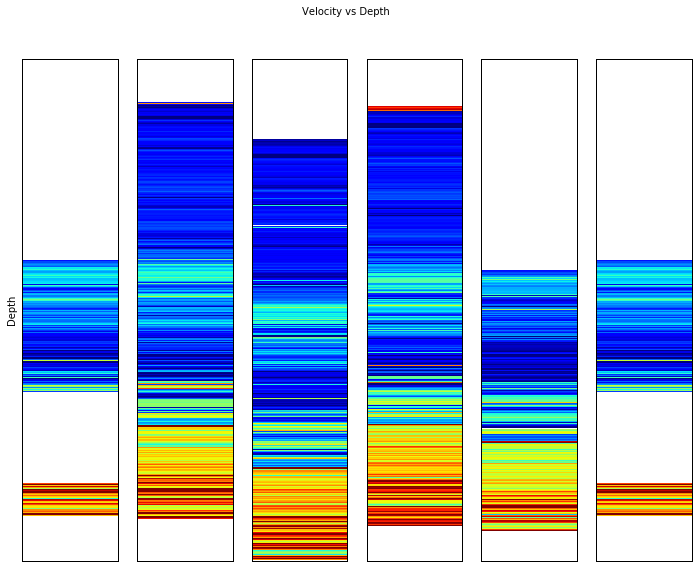

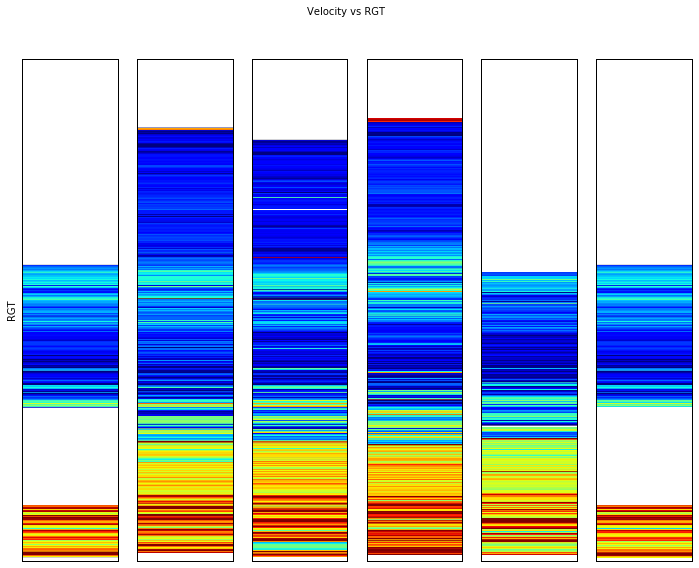

In [40]:
plot_logs(decimated_orig_logs, 'VEL', title='Velocity vs Depth')
plot_logs(decimated_orig_logs, 'VEL', yfield='RGT', title='Velocity vs RGT')

Success!

Although the results do not look very similar to those in the research report, the method still seems to have done a good job of aligning the logs. The most obvious change caused by the method is that the third log has been shifted to align it with the other logs. The end of the first log has also been stretched, and now seems to be a better match with the other logs. It seems that the sixth of these logs is actually the same as the first, so I suppose we can really only claim that we aligned five logs.

The logs had other properties in addition to `DT`. They don't all have the same properties, but when dynamic warping is applied to a pair of logs, it uses all of the properties that they have in common to determine the optimal alignment. So the method was not just trying to align slowness, but all of these other properties as well, many of which are very noisy.

## Applications

The most obvious use for the method is to aid in the construction of a 3D stratigraphic model. It could also be used to estimate variations in compaction.

Another application, and the one that inspired me to explore the method, is for machine learning. The [2016 SEG Machine Learning (ML) Contest](https://github.com/seg/2016-ml-contest/) asked entrants to predict facies from well logs. RGT looked like it should be quite a good predictor, so I used Wheeler and Hale's method (with my approximations) to create it as a feature for [my entry](https://github.com/seg/2016-ml-contest/blob/master/ar4/ar4_submission3.ipynb). I didn't win, but I don't think that was Wheeler and Hale's fault.

## Conclusion

The method worked well when I applied it to the Machine Learning contest dataset, but those logs were wonderfully well behaved. The Teapot Dome logs are shocking in comparison. For many of the log parameters, when I looked at the logs, I couldn't see any amount of shifting or stretching that would make the different logs look somewhat aligned. Yet, even for this noisy dataset, the method still seems to have done a pretty good job. I am also pleased with how easy it was to implement. A successful first attempt at *Reproducing Geophysics*.
